# Inference of discrete power law exponents

- Kristina Grigaityte, Cold Spring Harbor Laboratory
- Mickey Atwal, Cold Spring Harbor Laboratory

Let's say we have a bunch of numerical data that are all positive integer numbers. If we **assume** that the data is generated by sampling from a **discrete power law distribution**, with some exponent $\gamma$, then the probability of observing a single data point $x$ is

$$
\begin{array}
\
\boxed{
p(x|\gamma)=\displaystyle{\frac{x^{- \gamma}}{\zeta(\gamma)}}} \hspace{1in} \mbox{for } x \in \mathbb{Z}^+,
\end{array}
$$
where
$$ \zeta(\gamma) = \frac{1}{1^\gamma} + \frac{1}{2^\gamma} + \frac{1}{3^\gamma} + \frac{1}{4^\gamma} + ... = \sum_{n=1}^{\infty} \frac{1}{n^\gamma}
$$
is the famous Riemann zeta function and ensures that the probability distribution is normalized, i.e. $\sum_{x_i=1}^{\infty} p(x_i|\gamma) = 1$.

You may have reasons to believe that the power law behaviour is not an appropriate description below a certain minimum value $x_{\min}$ or above a certain maximum value $x_{\max}$. We can modify the above probability formula to focus on the relevant data regime:

$$
\begin{array}
\
\boxed{
p(x|\gamma)=\displaystyle{\frac{x^{- \gamma}}{Z (\gamma, x_{\min}, x_{\max})}}} \hspace{1in} \mbox{for } x \in \mathbb{Z}^+, \ x_{\max} \geq x \geq x_{\min},
\end{array}
$$
where
$$ Z(\gamma,x_{\min},x_{\max}) = \frac{1}{{(x_{\min})^\gamma}} + \frac{1}{(1+x_{\min})^\gamma} + \frac{1}{(2+x_{\min})^\gamma} + ... + \frac{1}{(x_{\max})^\gamma} = \sum_{n=x_\min}^{x_\max} \frac{1}{n^\gamma}
$$
Note that $Z({\gamma,1,\infty})$ is equivalent to the Riemann zeta function.

Any data that falls out of our $[x_\min,x_\max]$ range is ignored for power law analysis. Let's assume that the remaining data consists of $N$ numerical values that, when histogrammed, we want to fit to a power law. The likelihood $l$ of the relevant dataset $\{x_1,x_2,...,x_N\}$ is then

$$
\begin{array}
ll &=&p(\text{data}|\gamma) \\
&=& p(x_1|\gamma) p(x_2|\gamma) ... p(x_N|\gamma) \\
&=& \prod_{i=1}^{N} p(x_i|\gamma) \\
&=& \prod_{i=1}^{N} \displaystyle{\frac{x_i^{- \gamma}}{Z(\gamma,x_{\min},x_{\max})}}
\end{array}
$$
It is often easier dealing with the log-likelihood $\mathcal{L}$ 
$$
\begin{array}
\
\mathcal{L} &=& \ln l \\
&=& \sum_{i=1}^{N} \ln \displaystyle{\frac{x_i^{- \gamma}}{Z(\gamma,x_{\min},x_{\max})}} \\
&=& \sum_{i=1}^{N} \left( \ln x_i^{-\gamma} - \ln Z(\gamma,x_{\min},x_{\max}) \right)\\
&=& - N \ln Z(\gamma,x_{\min},x_{\max}) - \gamma \sum_{i=1}^{N} \ln x_i
\end{array}
$$
To find the value of the exponent $\gamma$ most likely to give rise to the data we maximize $\mathcal{L}$
$$
\begin{array}
\
\displaystyle{\frac{d \mathcal{L}}{d \gamma}} &=& 0 
\end{array}
$$
Carrying out this derivative gives us the following transcendental equation

$$
\begin{array}
\
\boxed{
\displaystyle{\frac{Z'(\gamma,x_\min,x_\max)}{Z(\gamma,x_\min,x_\max)}} = - \displaystyle{\frac{1}{N}} \sum_{i=1}^{N} \ln x_i} \hspace{0.5in} \text{Maximum Likelihood Equation} 
\end{array}
$$
where $Z'$ denotes differentiation of $Z$ with respect to $\gamma$.

### Iterative method to find maximum likelihood solution ###

We want to solve the following equation for $\gamma$
$$
F(\gamma)=0
$$
where 
$$
F(\gamma)=\frac{Z'(\gamma,x_\min,x_\max)}{Z(\gamma,x_\min,x_\max)} + \underbrace{\frac{1}{N} \sum_{i=1}^{N} \ln x_i}_{\rm constant}
$$
Note that the second term in $F(\gamma)$ is a constant independent of $\gamma$. This equation is impossible to solve analytically. Instead we can use an interative numerical method (Newton-Raphson) to solve for $\gamma$.

In [31]:
from __future__ import division
from scipy.optimize import newton 
from scipy.special import zeta
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Defining the functions

In [32]:
def powerlawpdf(x,gamma):
    """The power law probability function
    Input: x - array of clone sizes; gamma - desired exponent.
    Output: array of probabilities of each clone size x."""
    return (x**(-gamma))/Z(gamma,xmin,xmax)

In [33]:
def Z(gamma,xmin=1,xmax=np.infty):
    """The normalization function Z.
    Note that default arguments of xmin and xmax make Z equivalent to Riemann zeta function which is already 
    implemented in Scipy as zeta(gamma,1)"""
    if np.isfinite(xmax):
        s=0
        for i in xrange(xmin,xmax+1):
            s+=(1/(i**gamma))
    else:
        s=zeta(gamma,xmin)
    return s

In [34]:
def F(gamma):
    """The optimization function F(gamma). C is the second term in the definition of F(gamma) and is independent of 
    gamma. C need to be defined before running the function. Function Z must be run beforehand as well."""
    h = 1e-8
    Z_prime = (Z(gamma+h,xmin,xmax) - Z(gamma-h,xmin,xmax))/(2*h)
    return (Z_prime/Z(gamma,xmin,xmax))+C

In [35]:
def powerlaw_pvs_tofit(df):
    """This function calculates clone sizes.
    Input: pandas dataframe of paired sequences.
    Returns: clone sizes of paired and single alpha and beta dataframes."""

    df['joint']=df['NSeqCDR3A']+'_'+df['NSeqCDR3B']

    paired=np.array(pd.DataFrame(df.joint.value_counts())).flatten()
    alpha=np.array(pd.DataFrame(df.NSeqCDR3A.value_counts())).flatten()
    beta=np.array(pd.DataFrame(df.NSeqCDR3B.value_counts())).flatten()

    return paired, alpha, beta

In [36]:
def powerlaw_paired_toplot(df):
    """This function calculates clone sizes and their frequencies.
    Input: pandas dataframe of paired sequences.
    Returns: numpy array of clone sizes, numpy array of clone size frequencies of paired dataframes."""

    df['joint']=df['NSeqCDR3A']+'_'+df['NSeqCDR3B']

    clone_size_count=np.array(pd.DataFrame(df.joint.value_counts()).joint.value_counts())
    clone_size=np.array(pd.DataFrame(df.joint.value_counts()).joint.value_counts().index)
    clone_size_frequency=np.divide(clone_size_count, np.sum(clone_size_count).astype(float))

    return clone_size, clone_size_frequency

In [37]:
def powerlaw_pvs_toplot(df,chain):
    """This function calculates clone sizes and their frequencies for split single alpha and beta dataframes.
    Input: df - pandas dataframe of paired sequences; chain - input which chain for calculating clone sizes and their frequencies
    Chain choices: alpha - NSeqCDR3A, beta - NSeqCDR3B
    Returns: numpy array of clone sizes, numpy array of clone size frequencies for desired chain."""

    clone_size_count=np.array(pd.DataFrame(df[chain].value_counts())[chain].value_counts())
    clone_size=np.array(pd.DataFrame(df[chain].value_counts())[chain].value_counts().index)
    clone_size_frequency=np.divide(clone_size_count, np.sum(clone_size_count).astype(float))

    return clone_size, clone_size_frequency

### Load data

In [45]:
#got to your file location.
!cd /Users/kgrigait/Desktop/new_data

In [46]:
#Load pared sequences data
TRp_1=pd.read_csv('S1/TRpairs_productive.txt', sep='\t')
TRp_2=pd.read_csv('S2/TRpairs_productive.txt', sep='\t')
TRp_3=pd.read_csv('S3/TRpairs_productive.txt', sep='\t')
TRp_4=pd.read_csv('S4/TRpairs_productive.txt', sep='\t')
TRp_5=pd.read_csv('S5/TRpairs_productive.txt', sep='\t')

In [47]:
#Find exponents for Xmin = 1, 2, 3, 4, 5
#Find clone sizes of paired, and single alpha and beta dataframes for each subject.
CCp_1,CCa_1,CCb_1=powerlaw_pvs_tofit(TRp_1)
CCp_2,CCa_2,CCb_2=powerlaw_pvs_tofit(TRp_2)
CCp_3,CCa_3,CCb_3=powerlaw_pvs_tofit(TRp_3)
CCp_4,CCa_4,CCb_4=powerlaw_pvs_tofit(TRp_4)
CCp_5,CCa_5,CCb_5=powerlaw_pvs_tofit(TRp_5)

#Put each array into a list in preparation for 'for-loops' when acquiring exponents.
sample_list_paired=[CCp_1,CCp_2,CCp_3,CCp_4,CCp_5]
sample_list_alpha=[CCa_1,CCa_2,CCa_3,CCa_4,CCa_5]
sample_list_beta=[CCb_1,CCb_2,CCb_3,CCb_4,CCb_5]

#Create zeros array where each row is a different subject, and each column is a different Xmin.
exponent_p=np.zeros((5,5))
exponent_a=np.zeros((5,5))
exponent_b=np.zeros((5,5))

In [48]:
#Find exponent values.
#Paired
for s in range(5):
    for i in range(5):
        xmin=i+1 #define Xmin
        xmax=np.infty #define Xmax (in this case always infinity)
        sample=sample_list_paired[s] #Choose a sample from previously prepared sample lists.
        data=sample[(sample>=xmin) & (sample<=xmax)] # filters the sample by Xmin and Xmax
        N=int(len(data)) # Find sample size post filtering
        C=np.sum(np.log(data))/N # Find the constant to be used in powerlawpdf function above
        initial_guess=2.0 #initial guess for the parameter gamma
        gamma_ML=newton(F,initial_guess)
        exponent_p[s,i]=gamma_ML

#Alpha chain
for s in range(5):
    for i in range(5):
        xmin=i+1
        xmax=np.infty
        sample=sample_list_alpha[s]
        data=sample[(sample>=xmin) & (sample<=xmax)]
        N=int(len(data))
        C=np.sum(np.log(data))/N
        initial_guess=2.0
        gamma_ML=newton(F,initial_guess)
        exponent_a[s,i]=gamma_ML

#Beta chain
for s in range(5):
    for i in range(5):
        xmin=i+1
        xmax=np.infty
        sample=sample_list_beta[s]
        data=sample[(sample>=xmin) & (sample<=xmax)]
        N=int(len(data))
        C=np.sum(np.log(data))/N
        initial_guess=2.0
        gamma_ML=newton(F,initial_guess)
        exponent_b[s,i]=gamma_ML

In [49]:
#Get mean exponent values and standard errors for each Xmin across the 5 subjects.
mean1_p=np.mean(exponent_p[:,0])
mean2_p=np.mean(exponent_p[:,1])
mean3_p=np.mean(exponent_p[:,2])
mean4_p=np.mean(exponent_p[:,3])
mean5_p=np.mean(exponent_p[:,4])

mean1_a=np.mean(exponent_a[:,0])
mean2_a=np.mean(exponent_a[:,1])
mean3_a=np.mean(exponent_a[:,2])
mean4_a=np.mean(exponent_a[:,3])
mean5_a=np.mean(exponent_a[:,4])

mean1_b=np.mean(exponent_b[:,0])
mean2_b=np.mean(exponent_b[:,1])
mean3_b=np.mean(exponent_b[:,2])
mean4_b=np.mean(exponent_b[:,3])
mean5_b=np.mean(exponent_b[:,4])

std1_p=np.std(exponent_p[:,0])
std2_p=np.std(exponent_p[:,1])
std3_p=np.std(exponent_p[:,2])
std4_p=np.std(exponent_p[:,3])
std5_p=np.std(exponent_p[:,4])

std1_a=np.std(exponent_a[:,0])
std2_a=np.std(exponent_a[:,1])
std3_a=np.std(exponent_a[:,2])
std4_a=np.std(exponent_a[:,3])
std5_a=np.std(exponent_a[:,4])

std1_b=np.std(exponent_b[:,0])
std2_b=np.std(exponent_b[:,1])
std3_b=np.std(exponent_b[:,2])
std4_b=np.std(exponent_b[:,3])
std5_b=np.std(exponent_b[:,4])

sem1_p=std1_p/(5**(1/2))
sem2_p=std2_p/(5**(1/2))
sem3_p=std3_p/(5**(1/2))
sem4_p=std4_p/(5**(1/2))
sem5_p=std5_p/(5**(1/2))

sem1_a=std1_a/(5**(1/2))
sem2_a=std2_a/(5**(1/2))
sem3_a=std3_a/(5**(1/2))
sem4_a=std4_a/(5**(1/2))
sem5_a=std5_a/(5**(1/2))

sem1_b=std1_b/(5**(1/2))
sem2_b=std2_b/(5**(1/2))
sem3_b=std3_b/(5**(1/2))
sem4_b=std4_b/(5**(1/2))
sem5_b=std5_b/(5**(1/2))

In [50]:
#Count clone sizes and frequences for plotting for paired, and single alpha and beta chain dataframes.
CS_prod_1, CS_freq_prod_1=powerlaw_paired_toplot(TRp_1)
CS_prod_2, CS_freq_prod_2=powerlaw_paired_toplot(TRp_2)
CS_prod_3, CS_freq_prod_3=powerlaw_paired_toplot(TRp_3)
CS_prod_4, CS_freq_prod_4=powerlaw_paired_toplot(TRp_4)
CS_prod_5, CS_freq_prod_5=powerlaw_paired_toplot(TRp_5)

CSA_prod_1, CSA_freq_prod_1=powerlaw_pvs_toplot(TRp_1, 'NSeqCDR3A')
CSA_prod_2, CSA_freq_prod_2=powerlaw_pvs_toplot(TRp_2, 'NSeqCDR3A')
CSA_prod_3, CSA_freq_prod_3=powerlaw_pvs_toplot(TRp_3, 'NSeqCDR3A')
CSA_prod_4, CSA_freq_prod_4=powerlaw_pvs_toplot(TRp_4, 'NSeqCDR3A')
CSA_prod_5, CSA_freq_prod_5=powerlaw_pvs_toplot(TRp_5, 'NSeqCDR3A')

CSB_prod_1, CSB_freq_prod_1=powerlaw_pvs_toplot(TRp_1, 'NSeqCDR3B')
CSB_prod_2, CSB_freq_prod_2=powerlaw_pvs_toplot(TRp_2, 'NSeqCDR3B')
CSB_prod_3, CSB_freq_prod_3=powerlaw_pvs_toplot(TRp_3, 'NSeqCDR3B')
CSB_prod_4, CSB_freq_prod_4=powerlaw_pvs_toplot(TRp_4, 'NSeqCDR3B')
CSB_prod_5, CSB_freq_prod_5=powerlaw_pvs_toplot(TRp_5, 'NSeqCDR3B')

In [51]:
#Pool all subjects into one dataframe (for FIGURE 1A)
TRp_all=pd.concat([TRp_1,TRp_2,TRp_3,TRp_4,TRp_5],axis=0)
CCp_all,CCa_all,CCb_all=powerlaw_pvs_tofit(TRp_all)
xmin=1
xmax=np.infty

#Find pooled data exponent when Xmin=1 for plotting pooled clone size distributions.
data=CCp_all #Paired
N=int(len(data))
C=np.sum(np.log(data))/N
initial_guess=2.0
exponent_p_all=newton(F,initial_guess)

data=CCa_all #Single alpha
N=int(len(data))
C=np.sum(np.log(data))/N
initial_guess=2.0
exponent_a_all=newton(F,initial_guess)

data=CCb_all #Single beta
N=int(len(data))
C=np.sum(np.log(data))/N
initial_guess=2.0
exponent_b_all=newton(F,initial_guess)

#Find clone sizes and their frequencies for pooled data
CS_prod_all, CS_freq_prod_all=powerlaw_paired_toplot(TRp_all)
CSA_prod_all, CSA_freq_prod_all=powerlaw_pvs_toplot(TRp_all, 'NSeqCDR3A')
CSB_prod_all, CSB_freq_prod_all=powerlaw_pvs_toplot(TRp_all, 'NSeqCDR3B')



### Plot Results

#### Figure 2A

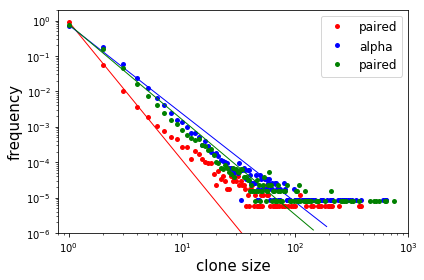

In [52]:
plt.figure()
#paired
#calculate max clone size used to generate a straight line fit.
xpmaxP=((Z(exponent_p_all,xmin,xmax)/len(CCp_all))**(-1/exponent_p_all))*2
xpP=np.arange(1,xpmaxP) #generate a straight line fit.
#Plot a scatter plot of clone size distribution.
plt.plot(CS_prod_all, CS_freq_prod_all, 'o', color='red', markeredgecolor='none', markersize=5.0,alpha=1,label='paired')
#Plot the linear fit of the clone size distribution.
plt.plot(xpP,powerlawpdf(xpP,exponent_p_all),'red',linewidth=1)

#alpha
xpmaxA=((Z(exponent_a_all,xmin,xmax)/len(CCa_all))**(-1/exponent_a_all))*2
xpA=np.arange(1,xpmaxA)
plt.plot(CSA_prod_all, CSA_freq_prod_all, 'o', color='blue', markeredgecolor='none', markersize=5.0,alpha=1,label='alpha')
plt.plot(xpA,powerlawpdf(xpA,exponent_a_all),'blue',linewidth=1)

#beta
xpmaxB=((Z(exponent_b_all,xmin,xmax)/len(CCb_all))**(-1/exponent_b_all))*2
xpB=np.arange(1,xpmaxB)
plt.plot(CSB_prod_all, CSB_freq_prod_all, 'o', color='green', markeredgecolor='none', markersize=5.0,alpha=1,label='paired')
plt.plot(xpB,powerlawpdf(xpB,exponent_b_all),'green',linewidth=1)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('clone size',fontsize=15)
plt.ylabel('frequency',fontsize=15)
plt.xlim([10**0-0.2,10**3])
plt.ylim([10**-6,10**0+1])
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(('All_powerlaw_pvs.png'))

#### Figure 2B

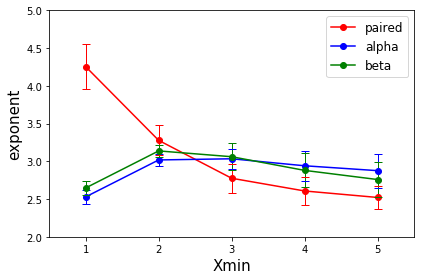

In [53]:
#Mean exponents for each Xmin to compare paired, and single alpha and beta chain clone size distributions.
plt.plot(range(1,6),([mean1_p,mean2_p,mean3_p,mean4_p,mean5_p]),color='red',  marker='o',label='paired')
plt.errorbar(range(1,6), ([mean1_p,mean2_p,mean3_p,mean4_p,mean5_p]), yerr=([sem1_p,sem2_p,sem3_p,sem4_p,sem5_p]), ls='none', color='red', elinewidth=1, capsize=4)
plt.plot(range(1,6),([mean1_a,mean2_a,mean3_a,mean4_a,mean5_a]),color='blue',  marker='o',label='alpha')
plt.errorbar(range(1,6), ([mean1_a,mean2_a,mean3_a,mean4_a,mean5_a]), yerr=([sem1_a,sem2_a,sem3_a,sem4_a,sem5_a]), ls='none', color='blue', elinewidth=1, capsize=4)
plt.plot(range(1,6),([mean1_b,mean2_b,mean3_b,mean4_b,mean5_b]),color='green',  marker='o',label='beta')
plt.errorbar(range(1,6), ([mean1_b,mean2_b,mean3_b,mean4_b,mean5_b]), yerr=([sem1_b,sem2_b,sem3_b,sem4_b,sem5_b]), ls='none', color='green', elinewidth=1, capsize=4)
plt.xlabel('Xmin',fontsize=15)
plt.ylabel('exponent',fontsize=15)
plt.ylim(2,5)
plt.xlim(0.5,5.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('mean_powerlaw_pvs_exponents.png')

#### Supplementary figure 2

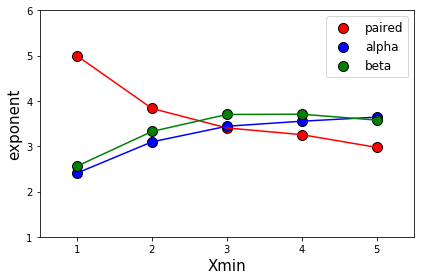

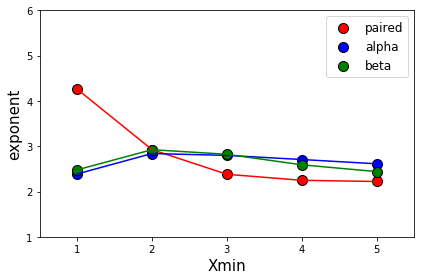

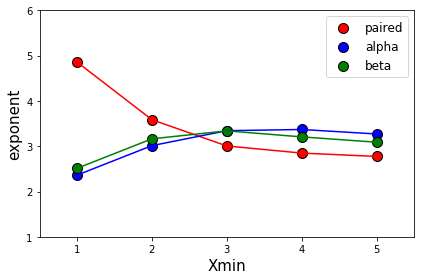

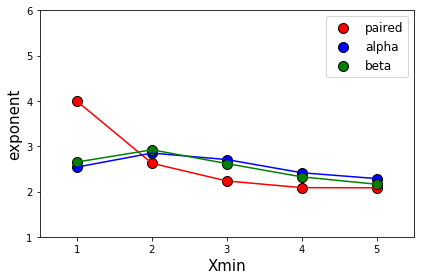

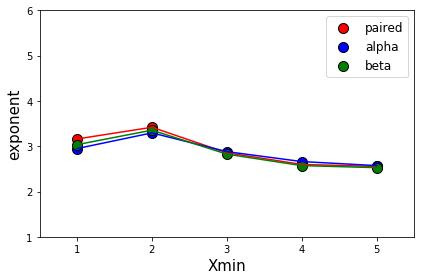

In [56]:
#Exponents for each individual subject for each Xmin.
for i in range(5):
    plt.figure()
    plt.plot(np.array(range(1,6)),exponent_p[i,:],'red')
    plt.scatter(np.array(range(1,6)),exponent_p[i,:],marker='o',color='red', edgecolor='black',s=100, label='paired')
    plt.plot(np.array(range(1,6)),exponent_a[i,:],'blue')
    plt.scatter(np.array(range(1,6)),exponent_a[i,:],marker='o',color='blue', edgecolor='black',s=100, label='alpha')
    plt.plot(np.array(range(1,6)),exponent_b[i,:],'green')
    plt.scatter(np.array(range(1,6)),exponent_b[i,:],marker='o',color='green', edgecolor='black',s=100,label='beta')
    plt.xlabel('Xmin',fontsize=15)
    plt.ylabel('exponent',fontsize=15)
    plt.ylim(1,6)
    plt.xlim(0.5,5.5)
    plt.legend(loc='upper right',fontsize=12)
    plt.tight_layout()
    plt.savefig(('S'+str(i+1)+'_powerlaw_pvs_exponents.png'))

#### Supplementary figure 1

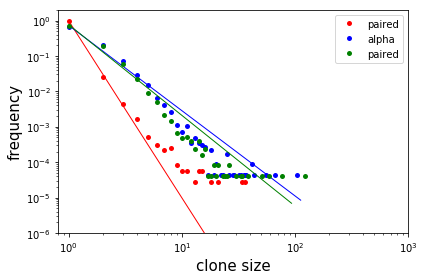

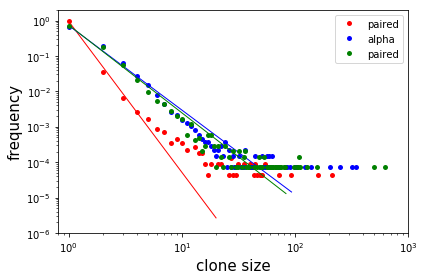

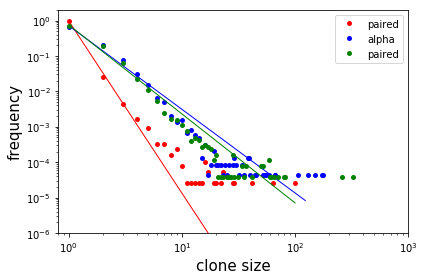

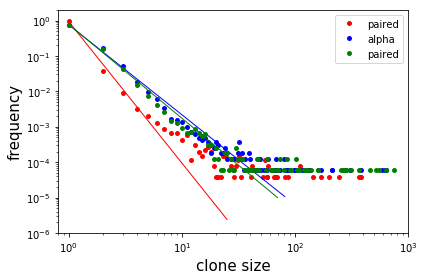

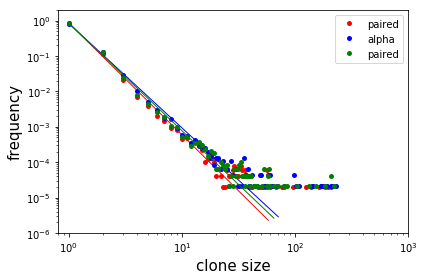

In [55]:
#Put clone size and their frequency arrays into list for the 'for-loop' for plotting.
CS_prod_list=[CS_prod_1,CS_prod_2,CS_prod_3,CS_prod_4,CS_prod_5]
CS_freq_prod_list=[CS_freq_prod_1,CS_freq_prod_2,CS_freq_prod_3,CS_freq_prod_4,CS_freq_prod_5]
CSA_prod_list=[CSA_prod_1,CSA_prod_2,CSA_prod_3,CSA_prod_4,CSA_prod_5]
CSA_freq_prod_list=[CSA_freq_prod_1,CSA_freq_prod_2,CSA_freq_prod_3,CSA_freq_prod_4,CSA_freq_prod_5]
CSB_prod_list=[CSB_prod_1,CSB_prod_2,CSB_prod_3,CSB_prod_4,CSB_prod_5]
CSB_freq_prod_list=[CSB_freq_prod_1,CSB_freq_prod_2,CSB_freq_prod_3,CSB_freq_prod_4,CSB_freq_prod_5]
CCp_list=[CCp_1,CCp_2,CCp_3,CCp_4,CCp_5]
CCa_list=[CCa_1,CCa_2,CCa_3,CCa_4,CCa_5]
CCb_list=[CCb_1,CCb_2,CCb_3,CCb_4,CCb_5]

#Clone size distributions of each individual subject.
xmin=1
for i in range(5):
    plt.figure()
    #paired
    xpmaxP=((Z(exponent_p[i,0],xmin,xmax)/len(CCp_list[i]))**(-1/exponent_p[i,0]))*2
    xpP=np.arange(1,xpmaxP)
    plt.plot(CS_prod_list[i], CS_freq_prod_list[i], 'o', color='red', markeredgecolor='none', markersize=5.0,alpha=1,label='paired')
    plt.plot(xpP,powerlawpdf(xpP,exponent_p[i,0]),'red',linewidth=1)
    #alpha
    xpmaxA=((Z(exponent_a[i,0],xmin,xmax)/len(CCa_list[i]))**(-1/exponent_a[i,0]))*2
    xpA=np.arange(1,xpmaxA)
    plt.plot(CSA_prod_list[i], CSA_freq_prod_list[i], 'o', color='blue', markeredgecolor='none', markersize=5.0,alpha=1,label='alpha')
    plt.plot(xpA,powerlawpdf(xpA,exponent_a[i,0]),'blue',linewidth=1)
    #beta
    xpmaxB=((Z(exponent_b[i,0],xmin,xmax)/len(CCb_list[i]))**(-1/exponent_b[i,0]))*2
    xpB=np.arange(1,xpmaxB)
    plt.plot(CSB_prod_list[i], CSB_freq_prod_list[i], 'o', color='green', markeredgecolor='none', markersize=5.0,alpha=1,label='paired')
    plt.plot(xpB,powerlawpdf(xpB,exponent_b[i,0]),'green',linewidth=1)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('clone size',fontsize=15)
    plt.ylabel('frequency',fontsize=15)
    plt.xlim([10**0-0.2,10**3])
    plt.ylim([10**-6,10**0+1])
    plt.legend()
    plt.tight_layout()
    plt.savefig(('S'+str(i+1)+'_powerlaw_pvs.png'))